In [1]:
import yfinance as yf

In [2]:
msft = yf.Ticker("MSFT")

# get all stock info
#msft.info

In [3]:
# get historical market data
hist = msft.history(period="max")

In [4]:
hist.index

DatetimeIndex(['1986-03-13 00:00:00-05:00', '1986-03-14 00:00:00-05:00',
               '1986-03-17 00:00:00-05:00', '1986-03-18 00:00:00-05:00',
               '1986-03-19 00:00:00-05:00', '1986-03-20 00:00:00-05:00',
               '1986-03-21 00:00:00-05:00', '1986-03-24 00:00:00-05:00',
               '1986-03-25 00:00:00-05:00', '1986-03-26 00:00:00-05:00',
               ...
               '2023-12-11 00:00:00-05:00', '2023-12-12 00:00:00-05:00',
               '2023-12-13 00:00:00-05:00', '2023-12-14 00:00:00-05:00',
               '2023-12-15 00:00:00-05:00', '2023-12-18 00:00:00-05:00',
               '2023-12-19 00:00:00-05:00', '2023-12-20 00:00:00-05:00',
               '2023-12-21 00:00:00-05:00', '2023-12-22 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=9523, freq=None)

<Axes: xlabel='Date'>

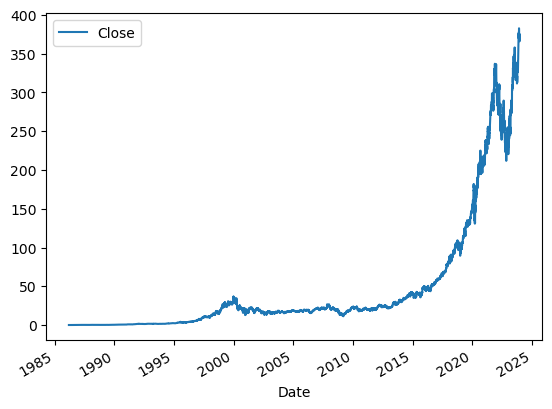

In [5]:
hist.plot.line(y="Close", use_index=True)

In [6]:
del hist['Dividends']
del hist['Stock Splits']

In [7]:
hist['Tomorrow'] = hist['Close'].shift(-1)

In [8]:
hist['Target'] = (hist['Tomorrow'] > hist['Close']).astype(int)

In [9]:
hist = hist.loc['1990-01-01':].copy()

In [10]:
#Create Random Forest Classifier model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

#Split data
train = hist.iloc[:-100]
test = hist.iloc[-100:]

#Prediction
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
#Accuracy Metrics
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [12]:
import pandas as pd

preds = pd.Series(preds, index=test.index)

In [13]:
precision_score(test['Target'], preds)

0.6140350877192983

<Axes: xlabel='Date'>

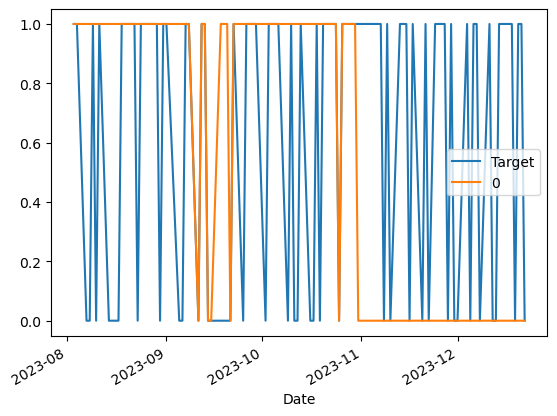

In [14]:
combined = pd.concat([test['Target'], preds], axis=1)
combined.plot()

In [15]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [16]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [17]:
predictions = backtest(hist, model, predictors)

In [18]:
predictions['Predictions'].value_counts()

0    3907
1    2154
Name: Predictions, dtype: int64

In [19]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5078922934076138

In [20]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.509157
0    0.490843
Name: Target, dtype: float64

In [21]:
#Assuming there are 250 trading days per year, we want to look at
#the last 2 days, week, 3 months, 1 year, and 4 years etc.

horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = hist.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    hist[ratio_column] = hist['Close'] / rolling_averages['Close']
    
    trend_column = f"Trend_{horizon}"
    hist[trend_column] = hist.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]

In [22]:
hist = hist.dropna()

In [23]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [25]:
predictions = backtest(hist, model, new_predictors)

In [26]:
predictions['Predictions'].value_counts()

0.0    4729
1.0     331
Name: Predictions, dtype: int64

In [27]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5287009063444109

In [28]:
#Adding in extra components such as other Indexes, Unemployment Rate, Time Series in Hour or Minute instead of by Days

In [32]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ', hist.shape)
print('Null Value Present: ', hist.isnull().values.any())

Dataframe Shape:  (7560, 17)
Null Value Present:  False


In [34]:
#Set Target Variable
output_var = pd.DataFrame(hist['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [37]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(hist[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=hist.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
1993-12-14 00:00:00-05:00,0.000127,0.000101,0.000064,0.052820
1993-12-15 00:00:00-05:00,0.000076,0.000076,0.000090,0.036712
1993-12-16 00:00:00-05:00,0.000076,0.000076,0.000090,0.028647
1993-12-17 00:00:00-05:00,0.000101,0.000051,0.000090,0.024682
1993-12-20 00:00:00-05:00,0.000127,0.000127,0.000129,0.037033


In [38]:
#Splitting to Training set and Test set
from sklearn.model_selection import TimeSeriesSplit
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [40]:
#Process the data for LSTM
import numpy as np
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [44]:
#Import Tensorflow for Long short-term memory (LSTM) network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [48]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [49]:
#Model Training
history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
860/860 [==============================] - 1s 506us/step - loss: 1198.9618
Epoch 2/100
860/860 [==============================] - 0s 487us/step - loss: 674.6611
Epoch 3/100
860/860 [==============================] - 0s 484us/step - loss: 587.6340
Epoch 4/100
860/860 [==============================] - 0s 491us/step - loss: 369.6884
Epoch 5/100
860/860 [==============================] - 0s 484us/step - loss: 191.7839
Epoch 6/100
860/860 [==============================] - 0s 478us/step - loss: 79.9670
Epoch 7/100
860/860 [==============================] - 0s 493us/step - loss: 29.4927
Epoch 8/100
860/860 [==============================] - 0s 485us/step - loss: 11.2567
Epoch 9/100
860/860 [==============================] - 0s 484us/step - loss: 5.3897
Epoch 10/100
860/860 [==============================] - 0s 481us/step - loss: 3.3434
Epoch 11/100
860/860 [==============================] - 0s 479us/step - loss: 2.3740
Epoch 12/100
860/860 [==============================] - 0s 4

In [50]:
#LSTM Prediction
y_pred = lstm.predict(X_test)

22/22 [==============================] - 0s 461us/step


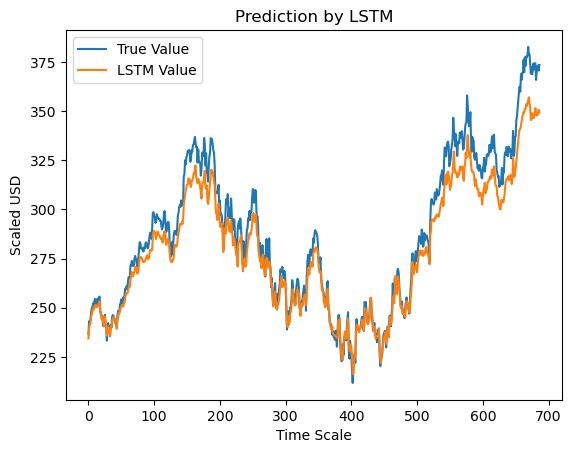

In [52]:
#Predicted vs True Adj Close Value – LSTM
import matplotlib.pyplot as plt
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()